In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import os

from ink_detection_utils import load_dataset
from ink_detection_utils import get_crop_numer_list
from ink_detection_utils import stitch_crops
from ink_detection_utils import load_volumes

from PIL import Image

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
#UNet Implementation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func

import random

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [3]:
test_img_1 = '../../Datasets/vesuvius-challenge-ink-detection/train/1/inkLabels.png'
test_img_2 = '../../Datasets/vesuvius-challenge-ink-detection/train/1/ir.png'

image_1 = Image.open(test_img_1)
image_2 = Image.open(test_img_2)

In [4]:
transform = transforms.Compose([
    transforms.RandomCrop(4000),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

In [5]:
seed = np.random.randint(2147483647) # make a seed with numpy generator
random.seed(seed) # apply this seed to img tranfsorms
torch.manual_seed(seed) # needed for torchvision 0.7

transformed_image_1 = transform(image_1)

In [6]:
random.seed(seed) # apply this seed to target tranfsorms
torch.manual_seed(seed) # needed for torchvision 0.7

transformed_image_2 = transform(image_2)

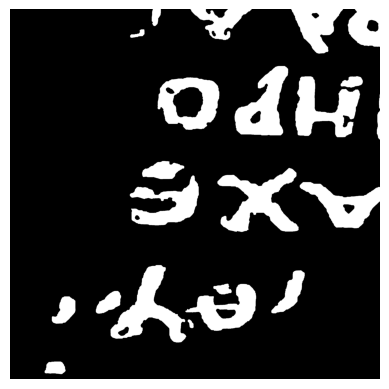

In [7]:
plt.imshow(transformed_image_1, cmap="gray") #last [] is the layer
plt.axis("off")
plt.show()

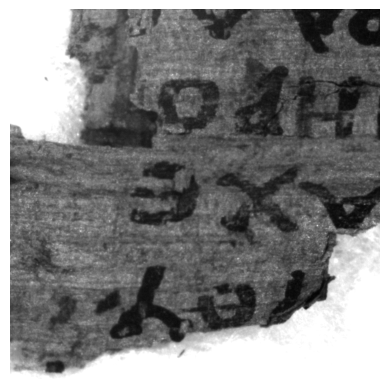

In [8]:
plt.imshow(transformed_image_2, cmap="gray") #last [] is the layer
plt.axis("off")
plt.show()

In [9]:
VESUVIUS_DATA_PATH = '../../Datasets/vesuvius-challenge-ink-detection/train/'

In [10]:
volume_paths = [VESUVIUS_DATA_PATH+'1/surface_volume/',VESUVIUS_DATA_PATH+'2/surface_volume/',VESUVIUS_DATA_PATH+'3/surface_volume/']
seg_paths = [VESUVIUS_DATA_PATH+'1/inkLabels.png',VESUVIUS_DATA_PATH+'2/inkLabels.png',VESUVIUS_DATA_PATH+'3/inkLabels.png']
mask_paths = [VESUVIUS_DATA_PATH+'1/mask.png',VESUVIUS_DATA_PATH+'2/mask.png',VESUVIUS_DATA_PATH+'3/mask.png']

In [22]:
torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [37]:
class FragmentDataset(Dataset):
    def __init__(self, volume_paths, seg_paths, mask_paths, transform=None):
        self.volume_paths = volume_paths
        self.seg_paths = seg_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.volume_paths)

    def __getitem__(self, idx):
        volume_path = self.volume_paths[idx]
        seg_path = self.seg_paths[idx]
        mask_path = self.mask_paths[idx]

        image_paths = [os.path.join(volume_path, file) for file in os.listdir(volume_path) if file.endswith('.tif')]

        volume = []

        seed = np.random.randint(2147483647) # make a seed with numpy generator

        for image_path in image_paths:
            image = Image.open(image_path)
            if self.transform is not None:

                random.seed(seed)
                torch.manual_seed(seed)

                image = self.transform(image)
            image_array = np.array(image)
            volume.append(image_array)

        volume = np.stack(volume)

        volume = torch.from_numpy(volume.reshape(volume.shape[0],volume.shape[2],volume.shape[3]))



        seg = np.array(Image.open(seg_path))
        if self.transform is not None:

            random.seed(seed)
            torch.manual_seed(seed)

            seg = self.transform(seg)

        mask = np.array(Image.open(mask_path))
        if self.transform is not None:

            random.seed(seed)
            torch.manual_seed(seed)

            mask = self.transform(mask)


        return volume ,seg, mask

In [63]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(70),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

# Create an instance of the FragmentDataset with the transformations
frag_data = FragmentDataset(volume_paths, seg_paths, mask_paths, transform=transform)

In [64]:
# Get an item from the dataset
idx = 0
volume, seg, mask = frag_data[idx]

# Print the shapes
print("Volume shape:", volume.shape)
print("Segment shape:", seg.shape)
print("Mask shape:", mask.shape)

Volume shape: torch.Size([65, 70, 70])
Segment shape: torch.Size([1, 70, 70])
Mask shape: torch.Size([1, 70, 70])


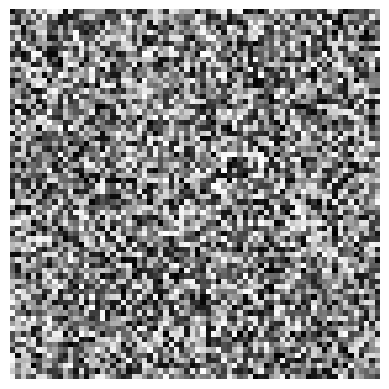

In [65]:
plt.imshow(volume[0], cmap="gray") #last [] is the layer
plt.axis("off")
plt.show()

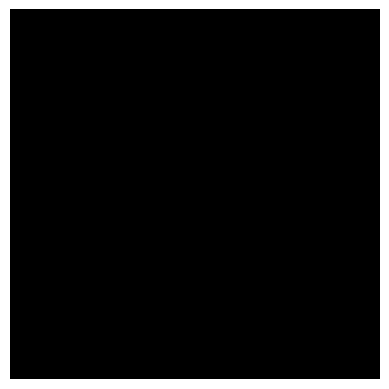

In [66]:
plt.imshow(seg[0], cmap="gray")
plt.axis("off")
plt.show()

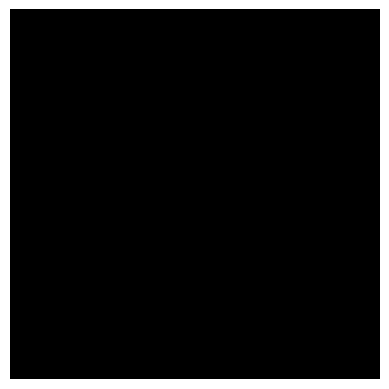

In [67]:
plt.imshow(mask[0], cmap="gray")
plt.axis("off")
plt.show()

In [69]:
#Simple UNet Model without skip connections

class UNetWithoutSkipConnections(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetWithoutSkipConnections, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=1),  # 68x68x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 34x34x16

            nn.Conv2d(16, 32, kernel_size=3, stride=1),  # 32x32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16x32

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 16x16x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8x64

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 8x8x128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 4x4x128
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, out_channels, kernel_size=2, stride=2, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [70]:
train_data = FragmentDataset(volume_paths, seg_paths, mask_paths, transform=transform)
val_data = FragmentDataset(volume_paths, seg_paths, mask_paths, transform=transform)
test_data = FragmentDataset(volume_paths, seg_paths, mask_paths, transform=transform)

Epoch 0 Processing Batch No: 1
Epoch [1/10], Train Loss: 14.2791, Test Loss: 7.7336
Epoch 1 Processing Batch No: 1
Epoch [2/10], Train Loss: 14.8593, Test Loss: 0.5932
Epoch 2 Processing Batch No: 1
Epoch [3/10], Train Loss: 2.1058, Test Loss: 0.8172
Epoch 3 Processing Batch No: 1
Epoch [4/10], Train Loss: 0.7158, Test Loss: 0.5526
Epoch 4 Processing Batch No: 1
Epoch [5/10], Train Loss: 0.5553, Test Loss: 0.4154
Epoch 5 Processing Batch No: 1
Epoch [6/10], Train Loss: 0.4979, Test Loss: 0.4761
Epoch 6 Processing Batch No: 1
Epoch [7/10], Train Loss: 0.4807, Test Loss: 0.3390
Epoch 7 Processing Batch No: 1
Epoch [8/10], Train Loss: 0.4657, Test Loss: 0.4349
Epoch 8 Processing Batch No: 1
Epoch [9/10], Train Loss: 0.3088, Test Loss: 0.4263
Epoch 9 Processing Batch No: 1
Epoch [10/10], Train Loss: 0.4381, Test Loss: 0.2393


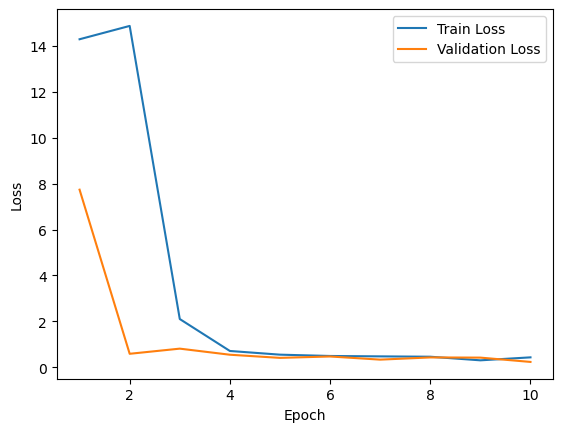

In [71]:
model = UNetWithoutSkipConnections(in_channels=65, out_channels=1)
model = model.to(device)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
batch_size = 128

best_test_loss = float('inf')

train_loader = DataLoader(frag_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0

    # Training
    model.train()

    batch_no = 1

    for batch in train_loader:

        print('Epoch',epoch,'Processing Batch No:', batch_no)

        images, labels, masks = batch[0].to(device), batch[1].to(device),batch[2].to(device)

        # Forward pass
        reconstructions = model(images)
        loss = criterion(reconstructions, labels.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        batch_no = batch_no + 1

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluation
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            images, labels, masks = batch[0].to(device), batch[1].to(device),batch[2].to(device)

            # Forward pass
            reconstructions = model(images)
            loss = criterion(reconstructions, labels.float())

            test_loss += loss.item() * images.size(0)

        test_loss /= len(val_loader.dataset)
        test_losses.append(test_loss)

        # Check if current model has the lowest test loss so far
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model_state = model.state_dict().copy()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Plotting train and test loss
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Load the best model state (lowest test loss)
model.load_state_dict(best_model_state)
torch.save(model, '../models/ink_detection_simple_u_net_middle_layer_epoch_'+str(num_epochs)+'_batch_'+str(batch_size)+'.pt')

In [80]:
test_loader = DataLoader(test_data, batch_size=60, shuffle=True)

In [81]:
model = torch.load('../models/ink_detection_simple_u_net_middle_layer_epoch_10_batch_128.pt')

model.eval()  # Set the model to evaluation mode

results_test = []

with torch.no_grad():
    for data in test_loader:
        # Move the batch to the GPU if available
        vol = data[0].to(device).to(torch.float32) if torch.cuda.is_available() else data[0].to(torch.float32)

        # Perform inference
        outputs = model(vol)
        results_test.append(outputs)

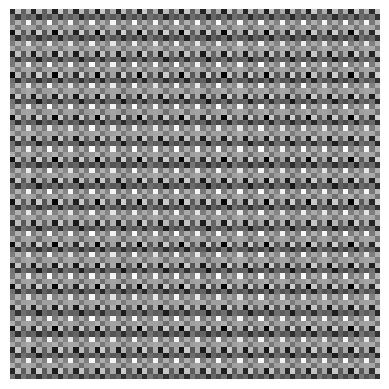

In [82]:
outputs_np = []
for result in results_test:
    # Convert the PyTorch tensor to a NumPy array
    outputs_np.append(result.cpu().numpy())

# Iterate over the outputs
for i in range(len(outputs_np)):
    output = outputs_np[i][0][0]

    # Display the output as an image
    plt.imshow(output, cmap='gray')  # Assuming grayscale images
    plt.axis('off')
    plt.show()